HAMILTONIAN PATH GRAPH GENERATION

In [1]:
import random 
# ------------------------------
# Graph construction (spec §2.1)
# ------------------------------
def add_connected_subgraph(graph, vertices, prob):
    L = vertices[:]
    random.shuffle(L)  # Step 1: random spanning path to ensure connectivity
    for k in range(len(L) - 1):
        u, v = L[k], L[k + 1]
        graph[u][v] = graph[v][u] = 1
    # Add extra random edges with p=1/2 among remaining pairs
    for i in range(len(vertices)):
        for j in range(i + 1, len(vertices)):
            u, v = vertices[i], vertices[j]
            if graph[u][v] == 0 and random.random() < prob:
                graph[u][v] = graph[v][u] = 1

    

def generate_tricky_graph(n, prob):
    N = 3 * n
    start = random.randint(0, N - 1)
    while True:
        end = random.randint(0, N - 1)
        if end != start:
            break

    graph = [[0] * N for _ in range(N)]

    A = list(range(0, n))
    B = list(range(n, 2 * n))
    C = list(range(2 * n, 3 * n))

    add_connected_subgraph(graph, A, prob)
    add_connected_subgraph(graph, B, prob)
    add_connected_subgraph(graph, C, prob)

    # Hide structure by permuting vertex labels; remap start/end accordingly
    perm = list(range(N))
    random.shuffle(perm)
    inv = [0] * N
    for i, p in enumerate(perm):
        inv[p] = i
    
    permuted = [[0] * N for _ in range(N)]
    for i in range(N):
        for j in range(N):
            permuted[i][j] = graph[perm[i]][perm[j]]
    graph = permuted
    start = inv[start]
    end = inv[end]

    return graph, start, end

BITMASK OPTIMIZED HAMILTONIAN PATH ALGORITHM

FIRST --> GET DFS TO CONTROL WHETHER STARTING NODE AND END NODE ARE IN THE SAME CLUSTER
SECOND --> IF SAME, CONVERT ADJ LIST INTO REDUCED FORMAT
THIRD --> APPLY BITMASK ALGORITHM

In [2]:
def dfs_from(adj_matrix, start_idx):
    n = len(adj_matrix)
    visited = [False] * n
    order = []
    stack = [start_idx]

    while stack:
        v = stack.pop()
        if visited[v]:
            continue
        visited[v] = True
        order.append(v)

        # Collect neighbors of v (where there's a 1 in the row)
        neighbors = [u for u, edge in enumerate(adj_matrix[v]) if edge]
        # Push in reverse so we pop the smallest index first
        for u in reversed(sorted(neighbors)):
            if not visited[u]:
                stack.append(u)

    return order


def compress_graph(adj, cluster_nodes):
    # map original node → 0..n-1
    idx = {node: i for i, node in enumerate(cluster_nodes)}
    n = len(cluster_nodes)

    # compressed adjacency
    comp_adj = [[0]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if adj[cluster_nodes[i]][cluster_nodes[j]] == 1:
                comp_adj[i][j] = 1

    return comp_adj, idx


def hamiltonian_path_bitmask_cluster(adj, start, end, cluster_nodes):
    # Step 1: compress graph to local (0..n-1)
    comp_adj, idx = compress_graph(adj, cluster_nodes)
    n = len(cluster_nodes)

    start_l = idx[start]
    end_l   = idx[end]

    # dp[mask][v] = whether we can reach v using nodes in mask
    dp = [[False]*n for _ in range(1 << n)]
    dp[1 << start_l][start_l] = True

    # Fill DP
    for mask in range(1 << n):
        if not (mask & (1 << start_l)): 
            continue  # path must include start

        for v in range(n):
            if not dp[mask][v]:
                continue

            # Try extending to neighbors
            for u in range(n):
                if not comp_adj[v][u]:
                    continue
                if mask & (1 << u):
                    continue  # already used

                # Cannot visit end unless this is the last step
                next_mask = mask | (1 << u)
                if u == end_l and next_mask != (1 << n) - 1:
                    continue

                dp[next_mask][u] = True

    full_mask = (1 << n) - 1

    # Check if solution exists
    if not dp[full_mask][end_l]:
        return None

    # Reconstruct path
    path = []
    mask = full_mask
    cur = end_l

    for _ in range(n):
        path.append(cluster_nodes[cur])  # convert back to original numbers
        prev_mask = mask ^ (1 << cur)

        if prev_mask == 0:
            break

        # find predecessor
        for u in range(n):
            if dp[prev_mask][u] and comp_adj[u][cur]:
                # end must be last
                if u == end_l and prev_mask != (1 << end_l):
                    continue
                cur = u
                mask = prev_mask
                break

    return path[::-1]



CASE IMPLEMENTATIONS
AVG CASE --> GET GRAPH WITH NODE CONNECTION PROBABILITY OF 0.5
BEST_CASE --> GET GRAPH WITH NODE CONNECTION PROBABILITY OF 0
WORST_CASE --> GET GRAPH WITH NODE CONNECTION PROBABILITY OF 1

In [3]:
from tqdm import tqdm
import time

def get_case_experimental(n1, n2, prob, case="avg"):
    n_list = []
    time_list = []

    # Progress bar for n values
    for n in tqdm(range(n1, n2), desc="Testing different n values"):
        graph, start, end = generate_tricky_graph(n, prob)
        cluster_nodes = dfs_from(graph, start)
        times = []

        # Progress bar for inner loop
        for i in tqdm(range(3*n), desc=f"Running paths for n={n}", leave=False):
            if i == start:
                continue

            starting_time = time.time()

            if i in cluster_nodes:
                path = hamiltonian_path_bitmask_cluster(graph, start, i, cluster_nodes)
                # print(f"path for {start}, {i} is {path}")   # <-- REMOVE for speed
            else:
                pass

            end_time = time.time()
            time_diff = end_time - starting_time   # FIXED (your code had reversed subtraction)
            times.append(time_diff)

        # Compute metrics
        if case == "avg":
            avg_time = sum(times) / (3*n - 1)
            time_list.append(avg_time)
        elif case == "worst":
            time_list.append(max(times))
        elif case == "best":
            time_list.append(min(times))

        n_list.append(n)

    return n_list, time_list


EXPERIMENTAL GRAPHS

Testing different n values: 100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


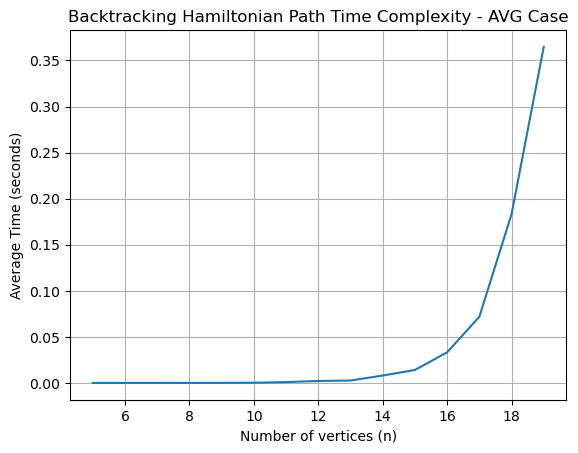

In [4]:
import matplotlib.pyplot as plt

avg_n_list, avg_time_list = get_case_experimental(5, 20, 0.5, "avg")

plt.plot(avg_n_list, avg_time_list)
plt.xlabel('Number of vertices (n)')
plt.ylabel('Average Time (seconds)')
plt.title('Backtracking Hamiltonian Path Time Complexity - AVG Case')
plt.grid()
plt.show()

Testing different n values: 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


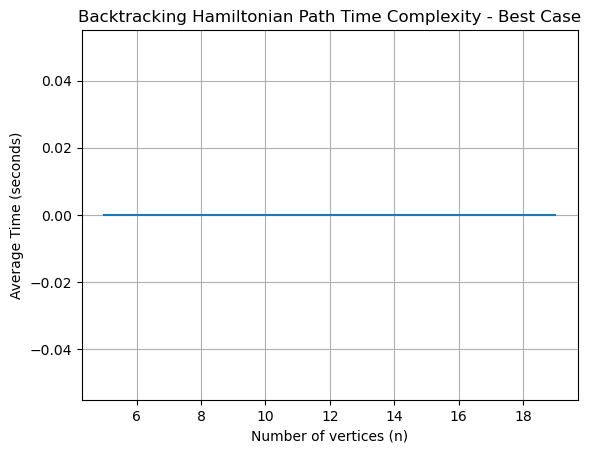

In [5]:
best_n_list, best_time_list = get_case_experimental(5, 20, 0.01, "best")

plt.plot(best_n_list, best_time_list)
plt.xlabel('Number of vertices (n)')
plt.ylabel('Average Time (seconds)')
plt.title('Backtracking Hamiltonian Path Time Complexity - Best Case')
plt.grid()
plt.show()

Testing different n values: 100%|██████████| 15/15 [00:53<00:00,  3.55s/it]


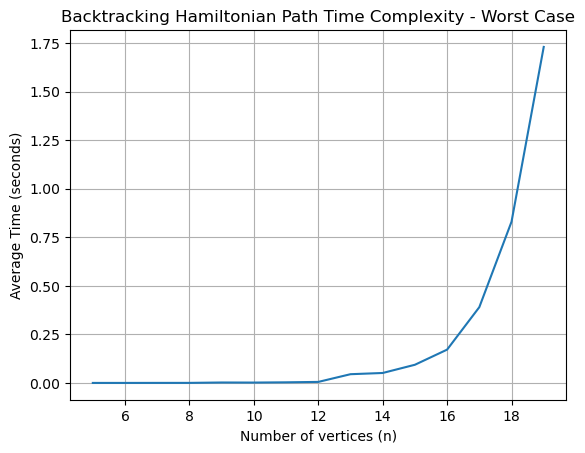

In [6]:
worst_n_list, worst_time_list = get_case_experimental(5, 20, 0.99, "worst")

plt.plot(worst_n_list, worst_time_list)
plt.xlabel('Number of vertices (n)')
plt.ylabel('Average Time (seconds)')
plt.title('Backtracking Hamiltonian Path Time Complexity - Worst Case')
plt.grid()
plt.show()